In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark with optimized configuration
spark = SparkSession.builder \
    .appName("EPA_AirQuality_Analysis") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

In [3]:
# EPA hourly data schema
epa_schema = StructType([
    StructField("State Code", StringType(), True),
    StructField("County Code", StringType(), True),
    StructField("Site Num", StringType(), True),
    StructField("Parameter Code", StringType(), True),
    StructField("POC", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Datum", StringType(), True),
    StructField("Parameter Name", StringType(), True),
    StructField("Date Local", DateType(), True),
    StructField("Time Local", StringType(), True),
    StructField("Date GMT", DateType(), True),
    StructField("Time GMT", StringType(), True),
    StructField("Sample Measurement", DoubleType(), True),
    StructField("Units of Measure", StringType(), True),
    StructField("MDL", DoubleType(), True),
    StructField("Uncertainty", DoubleType(), True),
    StructField("Qualifier", StringType(), True),
    StructField("Method Type", StringType(), True),
    StructField("Method Code", StringType(), True),
    StructField("Method Name", StringType(), True),
    StructField("State Name", StringType(), True),
    StructField("County Name", StringType(), True),
    StructField("Date of Last Change", DateType(), True)
])

In [5]:
# Load multiple EPA hourly files
def load_epa_data(year, parameter_code):
    file_path = f"data/hourly_{parameter_code}_{year}.csv"
    return spark.read.schema(epa_schema).option("header", "true").csv(file_path)

# Example: Load PM2.5 data for 2022 and 2023
pm25_2023 = load_epa_data(2023, "88101")
pm25_2024 = load_epa_data(2024, "88101")

# Combine datasets
aq_df = pm25_2023.union(pm25_2024)

# Create proper timestamp
aq_df = aq_df.withColumn(
    "timestamp",
    to_timestamp(
        concat(col("Date Local"), lit(" "), col("Time Local")),
        "yyyy-MM-dd HH:mm"
    )
)

# Select relevant columns
aq_df = aq_df.select(
    "State Name", "County Name", "Parameter Name",
    "timestamp", "Sample Measurement", "Units of Measure",
    "Latitude", "Longitude"
)

# Rename columns for easier handling
aq_df = aq_df.withColumnRenamed("Sample Measurement", "value") \
             .withColumnRenamed("Parameter Name", "pollutant") \
             .withColumnRenamed("Units of Measure", "unit")

# Cache the DataFrame
aq_df.cache()

DataFrame[State Name: string, County Name: string, pollutant: string, timestamp: timestamp, value: double, unit: string, Latitude: double, Longitude: double]

In [6]:
# 4. Data Quality Checks - Final Corrected Version

from pyspark.sql.types import DoubleType, FloatType, IntegerType, LongType, StringType, TimestampType

def check_missing_values(df):
    """Check for missing values in all columns with proper type handling"""
    print("Missing values per column:")
    
    # Create expressions for each column type
    numeric_exprs = [
        count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
        for c in df.columns 
        if isinstance(df.schema[c].dataType, (DoubleType, FloatType))
    ]
    
    other_exprs = [
        count(when(col(c).isNull(), c)).alias(c) 
        for c in df.columns 
        if not isinstance(df.schema[c].dataType, (DoubleType, FloatType))
    ]
    
    # Combine and execute
    missing_counts = df.select(numeric_exprs + other_exprs)
    missing_counts.show()

# Check missing values
check_missing_values(aq_df)

# Get numeric columns safely
numeric_cols = [
    f.name for f in aq_df.schema.fields 
    if isinstance(f.dataType, (DoubleType, FloatType, IntegerType, LongType))
]

# Basic statistics for numeric columns only
if numeric_cols:
    aq_df.select(numeric_cols).describe().show()
else:
    print("No numeric columns found for statistical analysis")

# Check data distribution by pollutant
aq_df.groupBy("pollutant").count().show()

# Check value ranges for measurement values
aq_df.select(
    min("value").alias("min_value"),
    max("value").alias("max_value"),
    mean("value").alias("avg_value"),
    stddev("value").alias("stddev_value")
).show()

# Additional data quality checks
print("Data quality metrics:")

# Check for invalid timestamps
aq_df.select(
    count(when(col("timestamp").isNull(), True)).alias("null_timestamps"),
    min("timestamp").alias("earliest_timestamp"),
    max("timestamp").alias("latest_timestamp")
).show()

# Check for invalid coordinates
aq_df.select(
    count(when((col("Latitude") < -90) | (col("Latitude") > 90), True)).alias("invalid_latitudes"),
    count(when((col("Longitude") < -180) | (col("Longitude") > 180), True)).alias("invalid_longitudes")
).show()

# Check for negative values where they shouldn't exist
aq_df.select(
    count(when(col("value") < 0, True)).alias("negative_measurements")
).show()

# Check for duplicate records
print("Potential duplicate records:")
aq_df.groupBy(aq_df.columns).count().where("count > 1").show()

aq_df = aq_df.drop_duplicates()

Missing values per column:
+-----+--------+---------+----------+-----------+---------+---------+----+
|value|Latitude|Longitude|State Name|County Name|pollutant|timestamp|unit|
+-----+--------+---------+----------+-----------+---------+---------+----+
|    0|       0|        0|         0|          0|        0|        0|   0|
+-----+--------+---------+----------+-----------+---------+---------+----+

+-------+-----------------+-----------------+------------------+
|summary|            value|         Latitude|         Longitude|
+-------+-----------------+-----------------+------------------+
|  count|         14099925|         14099925|          14099925|
|   mean|8.052775670792576|38.37567560424807|-94.52035484273384|
| stddev|9.616299393970131|5.517643537940178|17.605846628461872|
|    min|           -999.0|        18.420089|       -158.088613|
|    max|           1075.5|         64.84593|        -66.150615|
+-------+-----------------+-----------------+------------------+

+----------

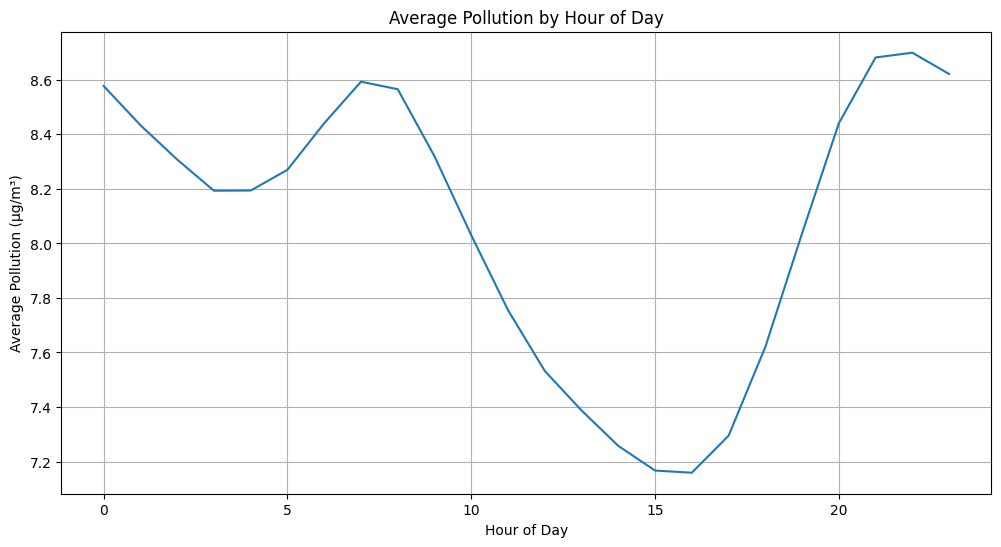

+------------+--------------------+------------------+
|  State Name|         County Name|     avg_pollution|
+------------+--------------------+------------------+
|        Utah|             Wasatch|14.077083333333333|
|       Texas|             Cameron|13.150707350901525|
|       Texas|             Hidalgo|12.936834077786248|
|      Oregon|              Harney|12.712391491617518|
|Pennsylvania|           Lancaster| 12.61037226058241|
|     Indiana|              Marion|12.467451323786944|
|    Michigan|           Kalamazoo|11.868956128952425|
|    Michigan|               Wayne|11.703981363828847|
|      Alaska|Fairbanks North S...| 11.46442511168587|
|Pennsylvania|        Philadelphia|11.447327767939973|
|     Georgia|              Walker|11.414498196372982|
|     Montana|             Lincoln|11.031829070396409|
|        Ohio|              Butler|11.024969980963544|
|    Oklahoma|              Nowata|11.020933758978453|
|     Georgia|           Dougherty|11.006596662681291|
|  Califor

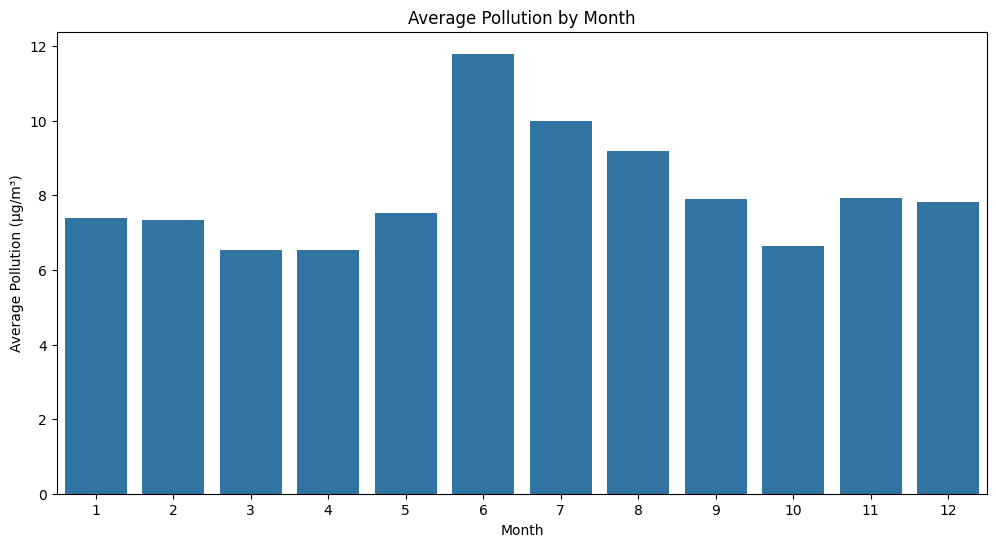

In [8]:
# Temporal analysis - pollution by hour of day
hourly_avg = aq_df.groupBy(hour("timestamp").alias("hour")) \
                 .agg(avg("value").alias("avg_pollution")) \
                 .orderBy("hour")

# Convert to Pandas for visualization
hourly_pd = hourly_avg.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="avg_pollution", data=hourly_pd)
plt.title("Average Pollution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Pollution (µg/m³)")
plt.grid(True)
plt.show()

# Spatial analysis - top polluted counties
county_avg = aq_df.groupBy("State Name", "County Name") \
                 .agg(avg("value").alias("avg_pollution")) \
                 .orderBy(desc("avg_pollution"))

county_avg.show(20)

# Seasonal analysis
monthly_avg = aq_df.groupBy(month("timestamp").alias("month")) \
                  .agg(avg("value").alias("avg_pollution")) \
                  .orderBy("month")

monthly_pd = monthly_avg.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="month", y="avg_pollution", data=monthly_pd)
plt.title("Average Pollution by Month")
plt.xlabel("Month")
plt.ylabel("Average Pollution (µg/m³)")
plt.show()

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.sql.functions import col, year, month, dayofweek, hour, lag

def prepare_features(df):
    """Safe feature preparation with validation"""
    # 1. Time features
    df = (df.withColumn("year", year("timestamp"))
          .withColumn("month", month("timestamp"))
          .withColumn("day_of_week", dayofweek("timestamp"))
          .withColumn("hour", hour("timestamp")))
    
    # 2. Lag features with proper partitioning
    window_spec = Window.partitionBy("State Name", "County Name").orderBy("timestamp")
    df = df.withColumn("prev_hour_value", lag("value", 1).over(window_spec))
    
    # 3. Handle nulls
    df = df.na.fill(0, subset=["prev_hour_value"])
    
    # 4. Index categorical features
    for col_name in ["State Name", "County Name"]:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name.lower().replace(' ', '_')}_index")
        df = indexer.fit(df).transform(df)
    
    return df

def validate_model_data(df):
    """Ensure data meets modeling requirements"""
    # Check required columns
    required = ["value", "hour", "day_of_week", "month", "year", 
               "prev_hour_value", "state_name_index", "county_name_index"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    
    # Check for NaN/infinite values
    for col_name in ["value", "prev_hour_value"]:
        if df.filter(col(col_name).isNull() | isnan(col(col_name))).count() > 0:
            raise ValueError(f"Null/NaN values found in {col_name}")
    
    # Check feature ranges
    if df.filter(col("value") < 0).count() > 0:
        print("Warning: Negative values found in target variable")

def train_model(train_data):
    """Safe model training with validation"""
    # Feature columns
    feature_cols = ["hour", "day_of_week", "month", "year",
                   "prev_hour_value", "state_name_index", "county_name_index"]
    
    # Assembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
    # Model with conservative settings
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="value",
        numTrees=50,
        maxDepth=5,
        maxBins=512,  # ✅ increase to handle high-cardinality features
        seed=42
    )
    
    # Pipeline
    pipeline = Pipeline(stages=[assembler, rf])
    
    # Train with try-catch
    try:
        return pipeline.fit(train_data)
    except Exception as e:
        print("Failed during model fitting:")
        print(f"Error: {str(e)}")
        print("Feature schema:")
        train_data.select(feature_cols).printSchema()
        print("Sample features:")
        train_data.select(feature_cols).show(5)
        raise

# Main execution
try:
    # 1. Prepare data
    print("Preparing features...")
    model_df = prepare_features(aq_df)
    
    # 2. Validate
    #print("Validating data...")
    #validate_model_data(model_df)
    
    # 3. Split data
    train_data, test_data = model_df.randomSplit([0.8, 0.2], seed=42)
    
    # 4. Cache data
    train_data.cache()
    print(f"Training on {train_data.count()} records")
    
    # 5. Train model
    print("Training model...")
    model = train_model(train_data)
    
    # 6. Evaluate
    predictions = model.transform(test_data)
    evaluator = RegressionEvaluator(
        labelCol="value", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"Model RMSE: {rmse}")

    evaluator = RegressionEvaluator(
        labelCol="value", predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(predictions)
    print(f"Model R^2: {r2}")
    
    # 7. Feature importance
    feature_cols = ["hour", "day_of_week", "month", "year",
                   "prev_hour_value", "state_name_index", "county_name_index"]
    rf_model = model.stages[-1]
    print("\nFeature Importance:")
    for feature, importance in zip(feature_cols, rf_model.featureImportances):
        print(f"{feature}: {importance:.4f}")
    
    importances = rf_model.featureImportances

    # Convert SparseVector to a list of importance scores
    if isinstance(importances, SparseVector):
        importance_values = importances.toArray().tolist()
    else:
        importance_values = importances  # in case it's already a dense vector
    # Create a DataFrame with feature names and their importance scores
    feature_importances = pd.DataFrame({
        'feature': ["hour", "day_of_week", "month", "year",
                   "prev_hour_value", "state_name_index", "county_name_index"],
        'importance': importance_values
    })
    from pyspark.ml.linalg import SparseVector
    # Sort by importance (descending)
    feature_importances = feature_importances.sort_values('importance', ascending=False)

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(feature_importances['feature'], 
                feature_importances['importance'],
                color='skyblue')

    plt.xlabel('Importance Score')
    plt.title('Feature Importances for PM2.5 Prediction')
    plt.gca().invert_yaxis()  # Show most important feature at top

    # Add value labels on each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01,  # x-position
                 bar.get_y() + bar.get_height()/2,  # y-position
                 f'{width:.3f}',  # text
                 ha='left', va='center')

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
finally:
    # Clean up
    train_data.unpersist()
    #spark.stop()

Preparing features...
Training on 11214957 records
Training model...
Model RMSE: 5.800992515459109
Model R^2: 0.6446730181301366

Feature Importance:
hour: 0.0001
day_of_week: 0.0017
month: 0.0200
year: 0.0031
prev_hour_value: 0.8944
state_name_index: 0.0202
county_name_index: 0.0606


NameError: name 'SparseVector' is not defined

In [11]:
spark.stop()